In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

import datetime as dt

from tqdm.auto import tqdm
from scipy import stats

plt.style.use('ggplot')
import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

In [ ]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(19,9)}
        )

# Задание 1 
Retention – один из самых важных показателей в компании.
Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 
Данные лежат в папке shared и имеют следующую структуру:

In [3]:

table_reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
table_session = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [4]:
table_reg

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [5]:
# Сконвертируем даты с unix в обычный формат.
table_reg.reg_ts = pd.to_datetime(table_reg.reg_ts, unit='s')
table_session.auth_ts = pd.to_datetime(table_session.auth_ts, unit='s')

In [6]:
#В таблице с регистрацией - по идее должны быть у нас только уникальные значения - проверим это.
if table_reg['uid'].nunique() == table_reg.shape[0]:
    print('В таблице только уникальные пользователи')
else:
    print('В таблице есть не уникальные значения')


В таблице только уникальные пользователи


In [7]:
# Приклием таблицу с регистрациями к таблице с сессиями. 
full_data = table_session.merge(table_reg, how = 'left', on = 'uid')

In [8]:
full_data

,auth_ts,uid,reg_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09
3,1999-07-31 03:50:15,2,1999-07-22 22:38:09
4,1999-08-05 17:49:39,2,1999-07-22 22:38:09
...,...,...,...
9601008,2020-09-23 15:13:54,1110618,2020-09-23 15:13:54
9601009,2020-09-23 15:14:46,1110619,2020-09-23 15:14:46
9601010,2020-09-23 15:15:39,1110620,2020-09-23 15:15:39
9601011,2020-09-23 15:16:31,1110621,2020-09-23 15:16:31


In [9]:
# Визуально видим, что всё приклеилось. Проверим всё ли у нас соединилось
full_data.isna().sum()

auth_ts    0
uid        0
reg_ts     0
dtype: int64

Пропусков нет, данные сцепились хорошо.

In [11]:
#найдем через какое время пользователи входили в продукт с момента регистрации.
full_data['difference'] = full_data['auth_ts'] - full_data['reg_ts']

In [12]:
full_data.dtypes

auth_ts        datetime64[ns]
uid                     int64
reg_ts         datetime64[ns]
difference    timedelta64[ns]
dtype: object

In [13]:
full_data['day_number'] = full_data['difference'].apply(lambda x: x.days)
full_data['day_number']

0           0
1           0
2           2
3           8
4          13
           ..
9601008     0
9601009     0
9601010     0
9601011     0
9601012     0
Name: day_number, Length: 9601013, dtype: int64

In [14]:
# Рассчитаем retention
retention_mean = full_data.groupby('day_number', as_index=False)\
    .agg({'uid':'nunique'})\
    .head(30)

In [15]:
retention_mean['normal'] = round(retention_mean['uid'] / retention_mean['uid'][0] * 100, 2)
retention_mean.rename(columns = {'uid': 'unique_id', 'normal': 'retention'}, inplace=True)
retention_mean

,day_number,unique_id,retention
0,0,1000000,100.00
1,1,40202,4.02
2,2,42991,4.30
3,3,49152,4.92
4,4,56070,5.61
5,5,63713,6.37
6,6,72773,7.28
7,7,43626,4.36
8,8,49667,4.97
9,9,50373,5.04


Text(0.5, 1.0, 'Общий график retention %')

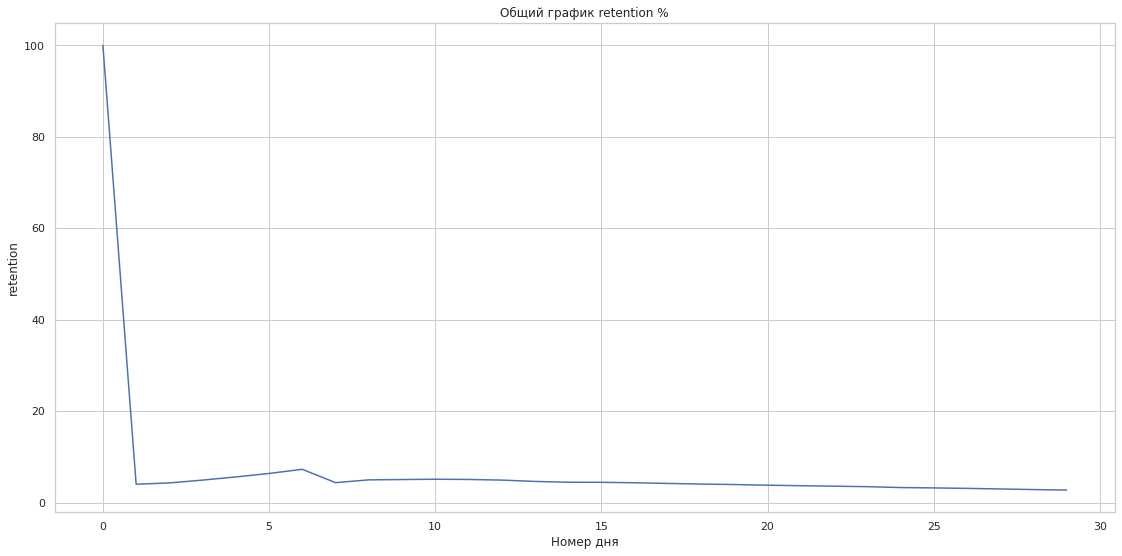

In [16]:
# Визуализируем результат.
sns.lineplot(data = retention_mean, x = 'day_number', y = 'retention')
plt.xlabel('Номер дня')
plt.ylabel('retention')
plt.title('Общий график retention %')

## Retention по месячным когортам


In [17]:
# переведем формат даты в формат: год-месяц.
#Сгруппируем наши данные по месячным когортам
full_data['mount_cogort'] = full_data['reg_ts'].astype('datetime64[M]')
retention_cogort = full_data.groupby(['mount_cogort','day_number'], as_index=False)\
    .agg({'uid':'nunique'})\

In [18]:
retention_cogort

,mount_cogort,day_number,uid
0,1998-11-01,0,1
1,1999-07-01,0,1
2,1999-07-01,2,1
3,1999-07-01,8,1
4,1999-07-01,13,1
...,...,...,...
294956,2020-09-01,18,299
294957,2020-09-01,19,201
294958,2020-09-01,20,135
294959,2020-09-01,21,67


In [19]:
# Проверим типы данных
retention_cogort.dtypes

mount_cogort    datetime64[ns]
day_number               int64
uid                      int64
dtype: object

In [20]:
# Ретентион будем считать до 14 дней
retention_cogort = retention_cogort.query('day_number <=14')

In [21]:
# переведем кол-во дней с момента регистрации в названия колонок, а даты в индексы
retention_cogort_pivot = retention_cogort.pivot(index = 'mount_cogort', columns = 'day_number', values = 'uid')
# Переведем название колонок в строковый формат
retention_cogort_pivot.columns = retention_cogort_pivot.columns.astype(str)
retention_cogort_mount = retention_cogort_pivot.div(retention_cogort_pivot['0'], axis = 0)

[Text(0, 0.5, '2020-01-01'),
 Text(0, 1.5, '2020-02-01'),
 Text(0, 2.5, '2020-03-01'),
 Text(0, 3.5, '2020-04-01'),
 Text(0, 4.5, '2020-05-01'),
 Text(0, 5.5, '2020-06-01'),
 Text(0, 6.5, '2020-07-01'),
 Text(0, 7.5, '2020-08-01'),
 Text(0, 8.5, '2020-09-01')]

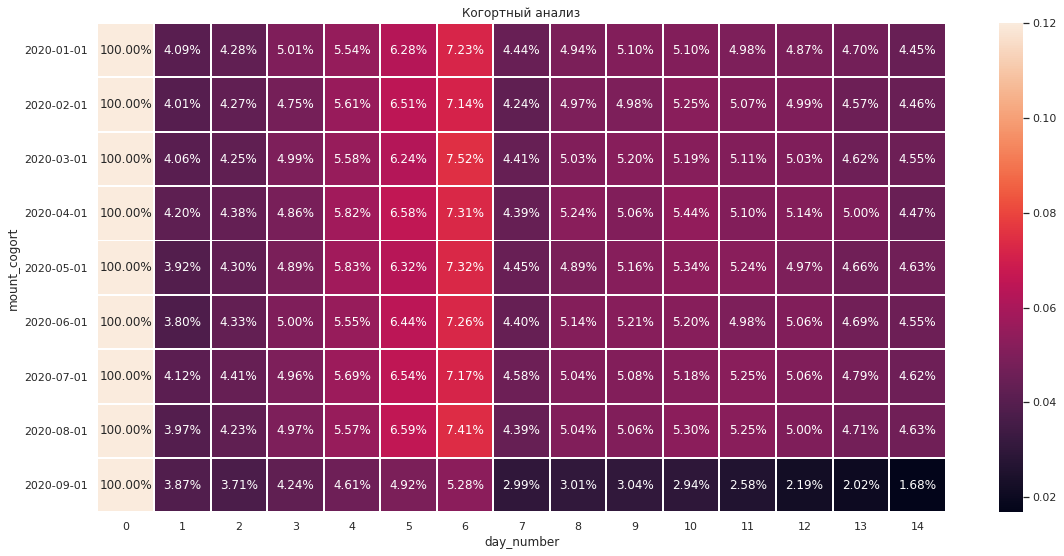

In [22]:
retention_2020 = retention_cogort_mount.loc['2020':]
plt.title('Когортный анализ')
ax = sns.heatmap(retention_2020, annot=True, fmt='.2%', linewidths=1, linecolor='white', vmax=0.12)
ax.set_yticklabels(retention_2020.index.date)

Напишем функцию, которая на вход будет брать:

1) Табличку c Регистрацией

2) Табличку с логами входов

3) Год и месяц регистрации пользователя начала когорты

4) Год и месяц регистрации последней когорты

5) Сколько дней будем смотреть.

In [24]:
def retention_1(data_1, data_2, dauuu, date_1, date_2):
    
#     data_1 - таблица с временем регистрации пользователя.
#     data_2 - Таблица с сессиями пользователей.
#     dauuu - на сколько дней выводить данные retention на графике.
#     date_1 - Минимальная дата когорты по которой рассчиытваем retention
#     date_2 - Максимальная дата когорты по которой рассчиытваем retention
        
    #Загружаем наши таблицы
    table_reg = pd.read_csv(data_1, sep=';')
    table_session = pd.read_csv(data_2, sep=';') 
    
    #переводим unix формат в стандартный формат даты.
    table_reg.reg_ts = pd.to_datetime(table_reg.reg_ts, unit='s')
    table_session.auth_ts = pd.to_datetime(table_session.auth_ts, unit='s')        
        
    #соедияем таблицы
    full_table =  table_session.merge(table_reg, how ='left', on='uid')
    
    #Сделаем возможность выбора разреза времени в самой функции, Т.е. месячные когорты по котормы будем смотреть retention
    full_table = full_table.loc[(full_table['reg_ts'] >= date_1) & (full_table['reg_ts'] <= date_2)]
        
    #Находим дистанцию в днях между регистрацией и сессией в днях
    full_table['difference'] = (full_table['auth_ts'] - full_table['reg_ts']).apply(lambda x: x.days)
    
    full_table['mount_cogort'] = full_table['reg_ts'].dt.strftime('%Y\%m')
    
    
    #Находим число пользователей, которые остаются на N Дней с момента регистрации по месячным когортам, а также
    #пропишем настройки за сколько дней хотим смотреть retention
    retention_cogort = full_table.groupby(['mount_cogort','difference'], as_index=False)\
        .agg({'uid':'nunique'})\
        .rename(columns = {'uid':'retention'})\
        .query('difference <= @dauuu')\
        .pivot(index = 'mount_cogort', columns = 'difference', values = 'retention')
    retention_cogort.columns = retention_cogort.columns.astype(str)
    retention_table = retention_cogort.div(retention_cogort['0'], axis = 0)
    
    grafik_retention = sns.heatmap(retention_table, annot=True, fmt='.2%', linewidths=1, linecolor='white',  vmax=0.12)
    plt.title('Retention по месяцам')
    ax.set_yticklabels(labels=retention_table.index, rotation=0)
    
  
        
    return grafik_retention

AxesSubplot(0.125,0.125;0.62x0.755)


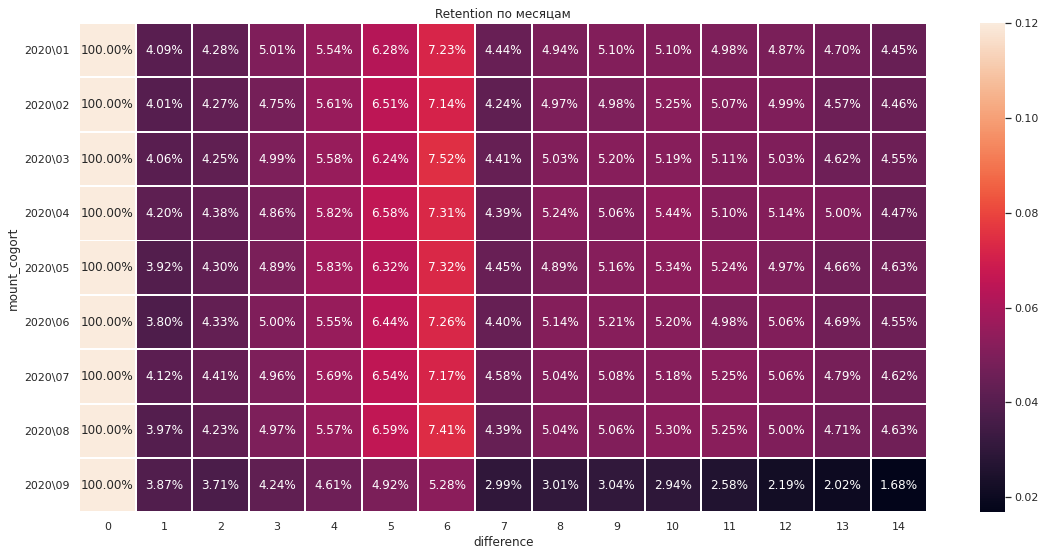

In [25]:
print(retention_1('~/shared/problem1-reg_data.csv', '~/shared/problem1-auth_data.csv', 14, '2020-01', '2020-10'))

Какие выводы можно сделать:

1) retention на следующий день очень падает, затем выходит на плато. Для игры retention первого дня выглядит ужасным.

Какие могут быть варианты:

    А) мы привлекаем не тех пользователей
    
    Б) мы не доносим ценности.
    
    В) Ценность есть но для малой игроков.
    
    
Рекомендации:
    1) Просмотреть логи пользователей, которые остаются на 7,14 Дни
    
    2) Посмотреть как они взаимодействуют с продуктом, постараться найти закономерности.
    
    3) Посмотреть бы визаульно что делают пользователи.
    
    4) Возможно построить retention Отдельных фич, которые используют пользователи. В продукте не все возможности имеют 
    одинаковую видимость.
    
    5) Провести пользовательски интервью с успешными игроками и понять их опыт и кто эти люди.


Что можем получить:

    Возможно большинство пользователей не видят ценность и если мы поймем опыт успешных игроков, сможем улучшить онбординг или
    изменить механику игры или сменить аудиторию привлечения.
  

# Задание 2 

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


### Общие рассуждения 
1) При акции возможно падение рентабельности и чистой прибыли с продажи.

2) при этом конверсия может вырасти, а может не изменится.

3) Может вырасти стат. значимо конверсия, но упасть чистый доход с одной продажи. Данные будет сложно сравнивать.

Как следствие, в подобных ситуациях лучше сравнивать доход на одного пользователя(включая не платящих), вероятнее всего
будем иметь дело с распределением отличным от нормального ввиду, того, что малый процент пользователей оплачивает и будет много нулевых значений. Вероятнее нам подойдет или u-тест или bootstrap, с предварительной проверкой данных на аномалии. Т.к. аномалии
при использовании bootstrap могут завышать завышать средний показатель, но в то же время он дает более интерпритируемый результат, нежеле u-тест.

Для начала мы проверим наши данные глазами, далее уже более точно определимся с методом проверки



In [26]:
# Загрузим данные
df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')

In [27]:
#Посмотрим на данные
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [28]:
#Проверим на наличие дубликатов.
df.duplicated().sum()

0

In [29]:
#Проверим наличие пропусков
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [30]:
CR_croup_a = df.query('testgroup == "a" and revenue > 0').shape[0] / df.query('testgroup == "a"').shape[0]
CR_croup_b = df.query('testgroup == "b" and revenue > 0').shape[0]/ df.query('testgroup == "a"').shape[0]
print('CR в оплату группы а: {:.2%}'.format(CR_croup_a))
print('CR в оплату группы b: {:.2%}'.format(CR_croup_b))

CR в оплату группы а: 0.95%
CR в оплату группы b: 0.89%


На взляд конверсия группы a выше - пока мы не сравниваем значимость различия и измерять будем другую метрику.

Посмотрим на доход с платящего пользователя. А также Посмотрим как распределены наши данные.

In [31]:
ARPPU_group_a = df.query('testgroup == "a" and revenue > 0').revenue.mean()
ARPPU_group_b = df.query('testgroup == "b" and revenue > 0').revenue.mean()
print('Средний доход на платящего пользователя группы а: {:.2f}'.format(ARPPU_group_a))
print('Средний доход на платящего пользователя группы b: {:.2f}'.format(ARPPU_group_b))

Средний доход на платящего пользователя группы а: 2664.00
Средний доход на платящего пользователя группы b: 3003.66


1) На глах Доход на 1-го платящего пользователя выше в группе б.

2) У нас ситуация в которой в одной группе на глазок конверсия выше, а в другой доход с платящего пользовтеля, тоже на глазок.
Далее мы сравним данные уже статистическим методом.



In [32]:
# Сравним доход на пользователя включая не платящих:
ARPU_group_a = df.query('testgroup == "a"').revenue.mean()
ARPU_group_b = df.query('testgroup == "b"').revenue.mean()
print('Средний доход на пользователя группы а (включая неплатящих): {:.2f}'.format(ARPU_group_a))
print('Средний доход на пользователя группы b (включая неплатящихх): {:.2f}'.format(ARPU_group_b))

Средний доход на пользователя группы а (включая неплатящих): 25.41
Средний доход на пользователя группы b (включая неплатящихх): 26.75


In [33]:
# Посмотрим на остальные описательные статистички для платящих пользователей

df.query('testgroup == "a" and revenue > 0').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [34]:
df.query('testgroup == "b" and revenue > 0').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Что здесь уже видно:

Медиана в группе B - выше почти в 10 раз. 

При этом максимальное значение дохода значительно выше в группе А.

А также в группе А - более высокий варативный признак. - смотрим стандартное отклонение.

#### Построим гистаграму распределения дохода на пользователя (включая неплатящих) для  группы а и группы б

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Гистограма распределения дохода на пользователя включая не платящих')

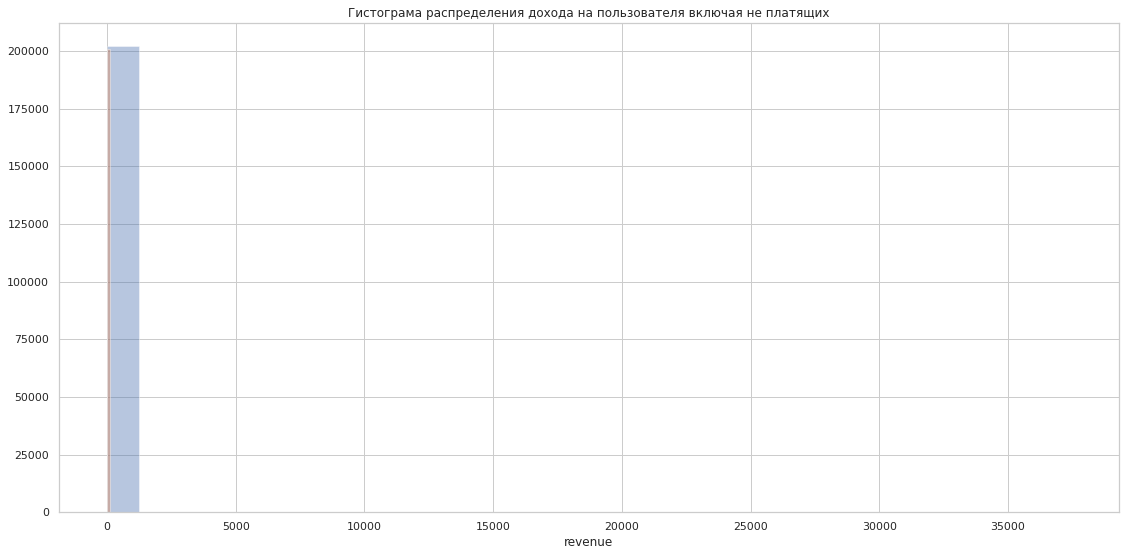

In [35]:
sns.distplot(df.query('testgroup == "a"').revenue, kde=False, bins=30)
sns.distplot(df.query('testgroup == "b"').revenue, kde=False, bins=30)
plt.title('Гистограма распределения дохода на пользователя включая не платящих')

У нас многие пользователи не совершили покупку, поэтому такой некрасивый график, где огромное большинство данных имеют 
нулевые значения. Удалим пользователей, которые совершили 0 покупок. И построим диграму распределения пользователей, которые 
делали покупку.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Гистограма распределения дохода на платящего пользователя')

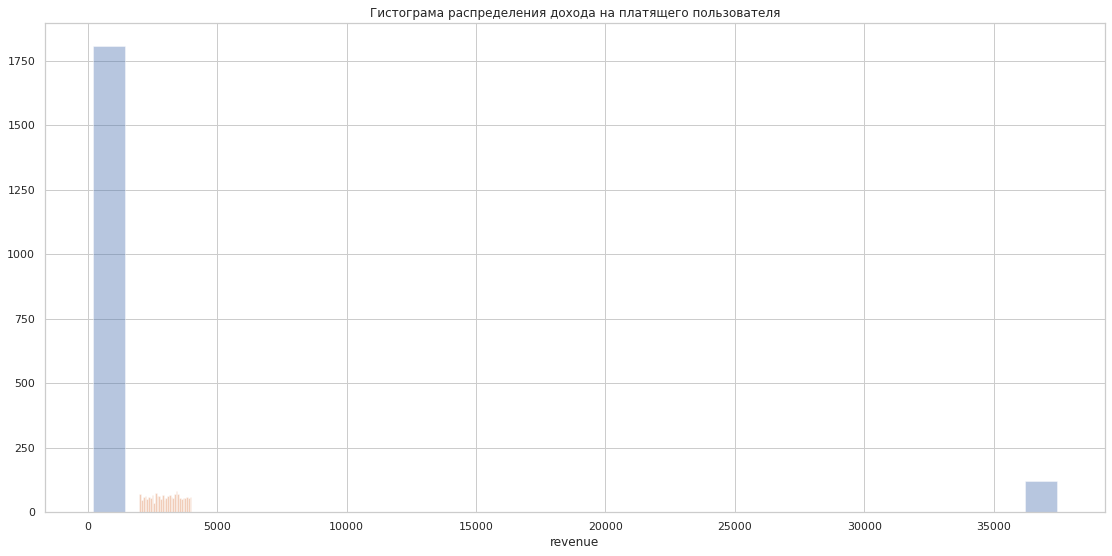

In [36]:
sns.distplot(df.query('testgroup == "a" and revenue > 0').revenue, kde=False, bins=30)
sns.distplot(df.query('testgroup == "b" and revenue > 0').revenue, kde=False, bins=30)
plt.title('Гистограма распределения дохода на платящего пользователя')

Есть сильные выбросы в одной из групп - данные выбросы было бы хорошо изучить отдельно. Построим дополнительно boxplot

Text(0.5, 1.0, 'Сравнение групп платящих пользователей')

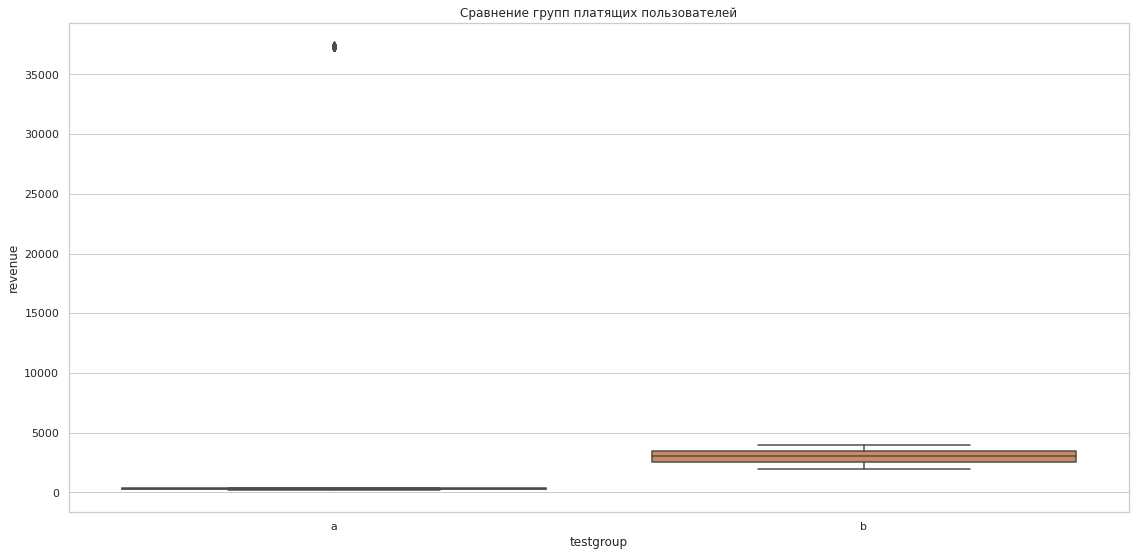

In [37]:
df_arr = df.query('revenue > 0')
sns.boxplot(data = df_arr, x = 'testgroup', y = 'revenue')
plt.title('Сравнение групп платящих пользователей')

In [38]:
# Что мы видим:
# А) есть аномальные значения в группе а. Уберем их и построим еще 1 боксплот.
df_no_anomaly = df_arr.query('revenue < 30000')
df_no_anomaly

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a
...,...,...,...
404315,404316,262,a
404525,404526,3120,b
404543,404544,369,a
404602,404603,251,a


Text(0.5, 1.0, 'Сравнение групп платящих пользователей с исключением аномалий')

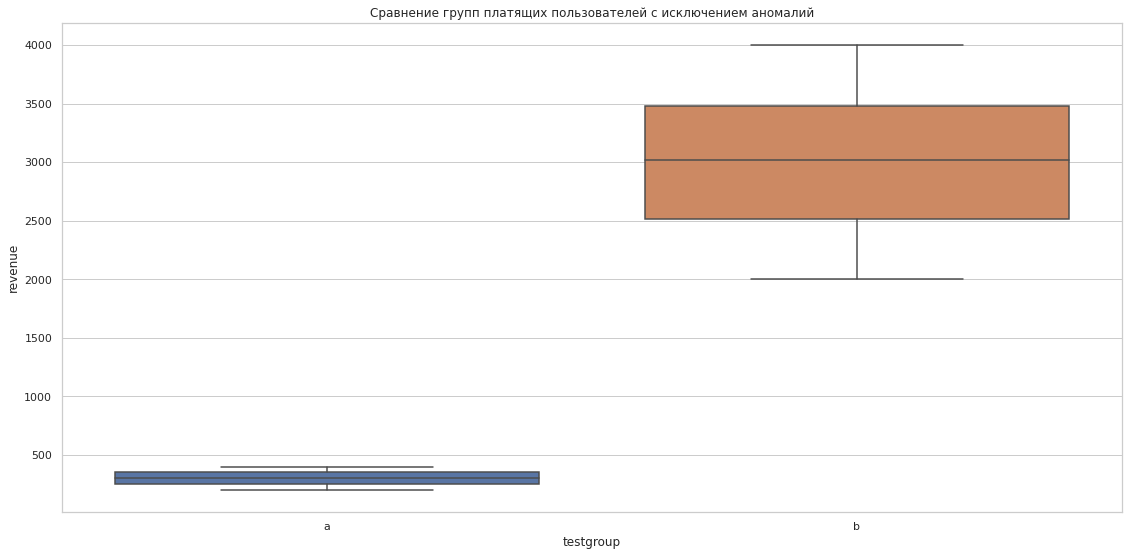

In [39]:
sns.boxplot(data = df_no_anomaly, x = 'testgroup', y = 'revenue')
plt.title('Сравнение групп платящих пользователей с исключением аномалий')

Если исключить выбросы - то уже без статистического критерия мы видем, что доход с платящего пользователя выше в группе b. 
Но просто так выбросить аномально высокие значения без знания их природы мы тоже не можем.

Что за аномалии? Какие варинты возможны:

А) Отдельный сегмент пользователей, который много платит и его не стоит исключать.

Б) Специфика акции - оч. дорого предложение в 1-ой из акций, которые небольшая часть пользователей приобрели, но нет в другой акции. - также не можем исключать.

В) Ошибки в данных - стоит исключить.

На самом деле как есть на самом деле мы можем только предполагать и давать какую либо вероятностную оценку. И по хорошему
пока причины аномалий не выясним лучше мы не можем проводить тест иначе растет вероятность принять неверное решение.


### Нужно проверить природу аномалий до того как делать статистический тест и выводы.

Учитывая, что у нас нет сведений о природе данных рассмотрим  ситуации.

А) Ошибка в данных. Узнали, что случайно нам попали данные пользователей оч старых и это доход прям за большое время, а не только за акцию.

Б) Это специфика акции - допустим оч. дорогое предложение или что то еще.



In [40]:
df_len_no_vibros = df.query('revenue > 0 and revenue <30000 and testgroup == "a"').shape[0]
print(df_len_no_vibros)

1805


In [41]:
Cr_no_vibros = df.query('revenue > 0 and revenue <30000 and testgroup == "a"').shape[0] / df.query('revenue <30000 and testgroup == "a"').shape[0]
print('Конверсия без аномальных значений в группе а: {:.2%}'.format(Cr_no_vibros))

Конверсия без аномальных значений в группе а: 0.89%


In [42]:
# такую же конверсию мы наблюдали и в тестовой группе
print('CR в оплату группы b: {:.2%}'.format(CR_croup_b))

CR в оплату группы b: 0.89%


### Что делаем по итогу - если узнали, что это ошибки в данных

##### Метод проверки: 
Bootstrap с исключением выбросов.
##### метрика: 
Средний доход на пользователя.
##### Что делаем по итогу эксперемента:
Если в тестовой группе доход на пользователя (включая не платящих) при исключении выбросов выше - используем акцию b, если различий нет, оставляем акцию a, если в группе а доход выше - оставляем акцию A.

In [43]:
group_a = df.query('testgroup == "a" and revenue < 30000').revenue
group_b = df.query('testgroup == "b" and revenue < 30000').revenue

### Сформируем нулевую и альтернативную гипотезу
H0 - средний заработок на одного пользователя(включая тех, кто не заплатил) не отличается в тестовой и контрольной группе

H1 - средний заработок на одного пользователя(включая тех, кто не запалатил) отличается.


In [3]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(group_control, group_test, boot_it = 10000, statistic = np.mean, bootstrap_conf_level = 0.95):
#     group_control -  числовые значения первой выборки
#     group_test - числовые значения второй выборки
#     boot_it - количество бутстрэп-подвыборок
#     statistic -  интересующая нас статистика
#     bootstrap_conf_level - уровень значимости
    
    boot_len = max([len(group_control), len(group_test)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = group_control.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = group_test.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { 
            "ci": ci, 
            "p_value": p_value}

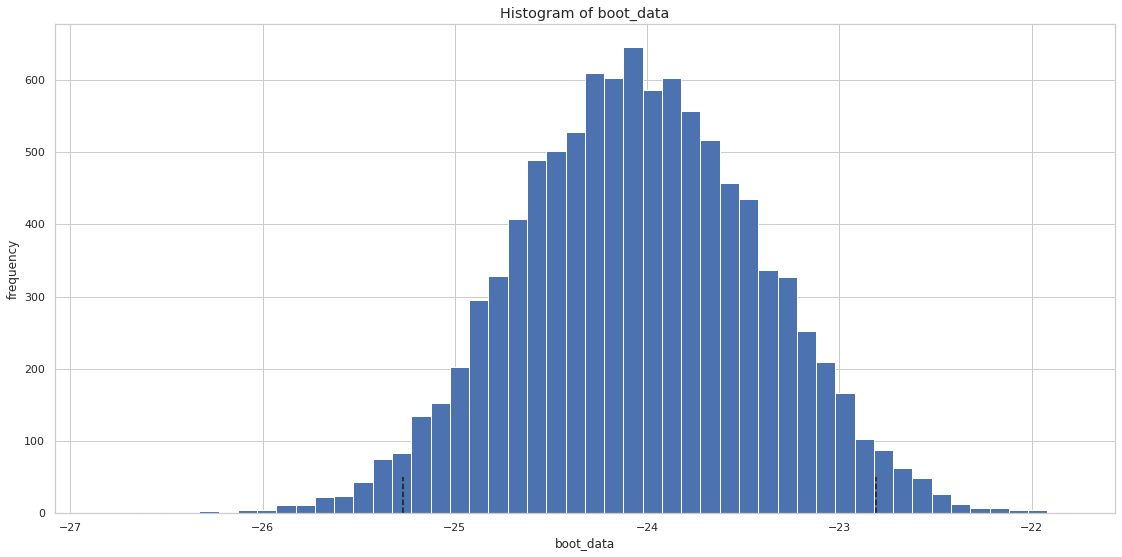

{'ci':                0
 0.025 -25.268229
 0.975 -22.809966,
 'p_value': 0.0}

In [45]:
get_bootstrap(group_a, group_b , boot_it = 10000)

p_value <0.05% - отклоняем нулевую гипотезу и принимаем альтернативную о том, что между двумя группами есть значимые различие в среднем. В группе a, средний доход на пользователя в среднем ниже на ~24 рубля.

### Выкатываем вторую версию акции на всех



### Вариант 2: - это особенности акции: - выбросы оставляем
##### Метод проверки: 
Bootstrap с исключением выбросов.
##### метрика: 
Средний доход на пользователя (включая неплатящих)
##### Что делаем по итогу эксперемента:
Если в  группе b доход на пользователя (включая не платящих) при исключении выбросов выше - используем акцию b, если различий нет, следует учесть издержки при обоих группах, если издержки одинаковые - предпочтительнее вариант b - ввиду более низкой вариативности, что стабильнее для бизнеса - или по усмотрению команды, но рекомендация оставить данные с меньшим вариативным признаком.. Если ср. значения группы а стат. значимо выше - оставляем акцию a.

In [46]:
group_a_vse = df.query('testgroup == "a"').revenue
group_b_vse = df.query('testgroup == "b"').revenue

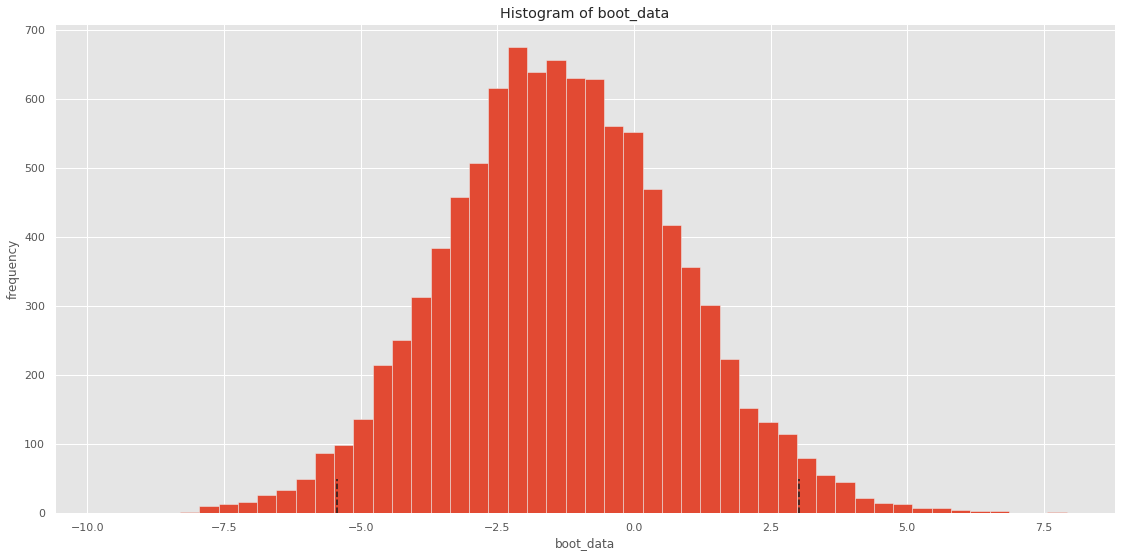

{'ci':               0
 0.025 -5.431033
 0.975  3.013178,
 'p_value': 0.5424603174791379}

In [47]:
get_bootstrap(group_a_vse, group_b_vse , boot_it = 10000)

P-value > 0.05. Т.е. если мы выбросы не исключаем, то у нас не достаточно данных, чтобы опровергнуть нулевую гипотезу и принимаем нулевую гипотезу, о том, что средний доход на пользователя в двух группах не отличается.



### Итоги исследования.
####  Случай 1 - аномально высокий доход на пользователя это ошибка.
Принимаем альтернативную гипотезу, о том, что между средним доходом на пользователя есть статистически значимая разница.
Средний доход на пользователя в группе b выше.

#### Случай 2 - аномально высокий доход на пользователя - это специфика акции.
Принимаем нулевую гипотезу о том, что средний доход на пользователя не отличается.


### Финальные выводы и рекомендации для бизнеса
Предполагаем, что издержки на акции одинаковые.

####  Случай 1 - аномально высокий доход на пользователя это ошибка.
Выкатываем версию B. т.к. это более выгодно.

#### Случай 2 - аномально высокий доход на пользователя - это специфика акции.
На усмотрение команды. Какая версия больше нравится. Стат. значимых различий нет.

=================== 

Для того, чтобы принять решение необходимо разобраться в причинах экстремальных значений.

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Ключевые метрики
##### 1. Среднее время активности на 1-го пользователя, который увидел мероприятие на n день, нормированное на день, когда увидел баннер.

Будем строить график и смотреть улучшилась ли активность. Сравнивать стат значимость на день:

0 день, 1 день, 7 дней, 14 дней

Мероприятие должно увеличить активность пользователя, как следствие увеличить кол-во взаимодействи и следовательно время активности в приложении.



##### 2. retention - день ноль будем считать момент когда пользователь увидел баннер.

Построим график + посмотрим показатели на: 

1 день

7 дней

14 дней

Одна из основных, но может быть менее чувствительной метрикой. Так или иначе нам необходимо наращивать аудиторию, долгосрочный retention в этом способствует.



##### 3. Монетизация (LTV)

Большинство действий мы делаем, чтобы увеличить монетизацию, точнее стараемся искать баланс между retention и LTV, нас интересуют долгие деньги, а не в моменте. Акционное мероприятие может сыграть в 2 стороны. С одной стороны мы даем бесплатно плюшки, что может негативно сказаться. С другой стороны время активности и retention Будет увеличиваться и в долгосрочной перспективе можем заработать больше, также получение бонусов и повышенная вовлеченнсоть могут способствовать наоборот дополнительным продажам, чтобы быстрее двигаться к достижению целей. Будем анализировать LTV на 30 день. Возможно и на др. периоды.


##### 4. Возврат не активных пользователей.

Будем смотреть вернулись ли пользователи, которые были неактивны.




###### Вспомогательные метрики.
Для того, чтобы детальнее понимать, как мероприятие вливается в жизнь пользователей.

А) Доля пользователей, которые увидели мероприятия и сделали первый шаг.

Б) Воронка от первого шага до последнего.  - будем смотреть как пользователи взаимодействуют, где отваливаются.

В) retention, среднее время активности, ltv на тех кто стал участником мероприятия и нет отдельно.

Может быть ситуация, что низкий конверт во взаимодействие с акцией - но метрики наши выше. Тогда будет стоять вопрос о том, как завлечь больше пользователей. И будет новая гипотеза и новый эксперемент.

Г) Какие призы выбирают, если есть выбор - для улучшения мероприятия




### Как будем по итогу принимать решение - на сколько акция хороша и стоит ли проводить
Гипотеза:
Если мы проведем мероприятие, то мы повысим вовлеченность пользователей. Т.е. время провождения в сервисе увеличится, увеличится кол-во событий, увеличится retention.

А) Основная метрика - Среднее время активности на пользователя:
Смотрим график и анализируем активность на n-день.  1-ый, 7-ой, 14-ый - Нормированное на пользователей, которые
хоть раз увидели баннер. 
Также отдельно будем смотреть на тех, кто начал проходить акцию - более чувствительная метрика. - Но необходимо быть осторожными, смотрим в том случае если не видим изменений на всех пользователях и как дополнительную. 

Б) При этом мы смотрим retention. Если время активности увеличивается retention и ltv не падают, проводим дальше, но пробуем разбираться почему не увеличивается retention, пытаемся доработать акцию. - возможно у нас отваливаются где то на воронке прохождения уровней, будем анализировать и улучшать, если LTV 30 дней падает в таком случае также необходимо будет думать как улучшать.

В) Идеальный вариант: активность растет, retention растет, монетизация увеличивается)



#### Попробуем съэмитировать разные ситуации.
1) Все метрики остались как были.
Смотрим конверсию в первое действие - оно низкое.
Смотрим в таком случае далее активность пользователей, которые начали проходить акцию. Видим например, что активность их выше.
Значит у нас новая гипотеза: Если мы повысим конверсию в первое действие мероприятия - мы увеличим число пользователей, которые
будут учавствовать - общая актиность вырастит. Здесь важно не путать корреляцию и причино следственную связь. Может пользователи
которые начали проходить просто сами по себе более активные. Поэтому только эксперементом мы сможем проверить нашу гипотезу.

2) Ср. время выросло. retention на месте.
Начинаем смотреть долю пользователей, которые начали юзать. Всё ок.
Смотрим активность по дням. Видим, что в первый день активность высокая (любопытство) а далее она падает до уровня которого была
а может и еще хуже. Мы понимаем - интерес к мероприятию есть - но оно сделано плохо. думаем над улучшением, проводим новый
эксперемент.

3) Ситуация 3 активность увеличлась как общая так и по дням. А Общий retention упал.
Начинам, смотреть что происходит. Видим, пользователи, которые проходят мероприятие - активность их выше.
А тех, кто виде и не начал - ниже и неизменная. При это общий retention упал.
А упал например у тех кто не юзает мероприятие, а у них сильно упал retention - может сильно назойливо рекламируем.
Следует пробовать убрать назойливость.
А может пользователи не хотят в акции, но меняется механика игры и негативно сказывается. Лучше откатывать - думать другое.

Может быть больше ситуаций. Поэтому мы смотрим верхнеуровневые метрики. Ср. время проведенное за периоды и retention.
Если всё везде хорошо гуд, но всегда можно сделать лучше - смотрим дальше)).
Если же вроде ничего не меняется - начинаем искать проблему. Выше я попробовал сэмитировать ситуации. Поэтому так или иначе нужно смотреть несколько метрик и принимать решение.

Оставллять акцию без проблем будем, если ср. время сессии увеличивается, retention и монетизация как миниму не страдают.




## Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад.

Основные метрики: ср. активность в разрезе дней и retention меняться не будут.
Но здесь лучше разделить при анализе пользователей на тех кто учавствовал в прошлой акции и не учавствовал отдельно.
Т.к. может быть ситуация, что старые игроки разочаруются и уйдут , а новым наоборот такое больше заинтересует. Т.е. анализируем отток пользователей.
Далее уже будем смотреть в абсолютных значениях на отток старых игроков и то как остаются новые. Что получаем в перспективе.
Основываясь на этом будем принимать решение. Но предпочтительнее повысить retention новых.

В целом здесь могут 2 ситуации - пользователи будут агриться на сложность и будут уходить или же наоборот это будет сильнее мотивировать и retention И активность вырастит.